In [7]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
import os

In [53]:
# Load the dataset
file_path = "/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)


print("Dataset Head:")
print(df.head())
print("--------------------------")
print("Dataset Info:")
print(df.info())

# Extract labels and image data
labels = df.iloc[:, 0].values  # First column contains the labels
images = df.iloc[:, 1:].values  # Remaining columns contain pixel values

# Properties
print(f"\nNumber of classes:")
print(len(np.unique(labels)))

print(f"Class distribution:")
print(pd.Series(labels).value_counts())

Dataset Head:
    0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB
No

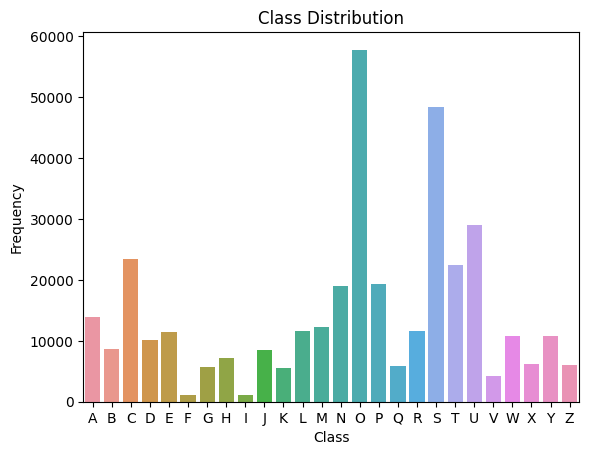

In [54]:
# Class distribution
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

alphabet = [chr(i) for i in range(65, 91)]  # Show Chars from A to Z
plt.xticks(ticks=np.arange(len(alphabet)), labels=alphabet)
plt.show()

# Normalize images
images_normalized = images / 255.0  # Scale to 0 & 1

# Reshape images
image_shape = (28, 28)  # Adjust dimensions
images_reshaped = images_normalized.reshape(-1, *image_shape)# -1 to ignore # of images




In [78]:
# Display 3 shapes for all characters
alphabet = [chr(i) for i in range(65, 91)]
unique_labels = np.unique(labels)  # Unique labels
print("labels: ")
print(labels)
# Find 3 images for each label
images_per_label = {}
for label in unique_labels:
    # Get the first 3 images for each character
    indices = np.where(labels == label)[0][:3]  
    images_per_label[label] = images_reshaped[indices]

labels: 
[ 0  0  0 ... 25 25 25]


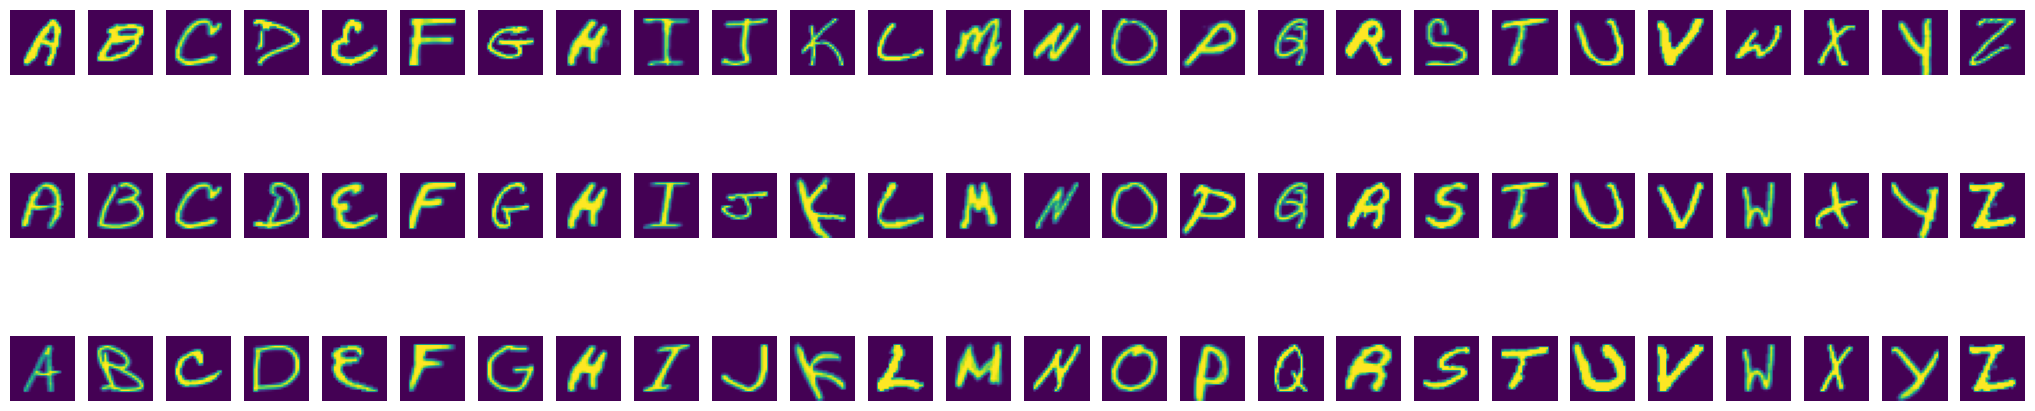

In [80]:
# Create a figure with subplots 3 rows, 26 columns
fig, axes = plt.subplots(3, 26, figsize=(26, 6))
for label in (unique_labels): #[0 - 25 , A - Z]
    for row in range(3):
        image = images_per_label[label][row]
        axes[row, label].imshow(image)#Show the image in the fig
        axes[row, label].axis('off')
plt.show()


 # SVM 

In [30]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    images_normalized, labels, test_size = 0.98, random_state=42, stratify=labels
)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
# Linear 
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)
# RBF 
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

Training data shape: (7449, 784), Testing data shape: (365001, 784)


SVC(random_state=42)

In [31]:
# Evaluate models
y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

# Make confusion matrices
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)

# F1 Scores for models
f1_linear = f1_score(y_test, y_pred_linear, average='weighted')# Can be average='None'
f1_rbf = f1_score(y_test, y_pred_rbf, average='weighted')# Can be average='None'

Linear SVM - F1 Score: 0.86
RBF SVM - F1 Score: 0.91


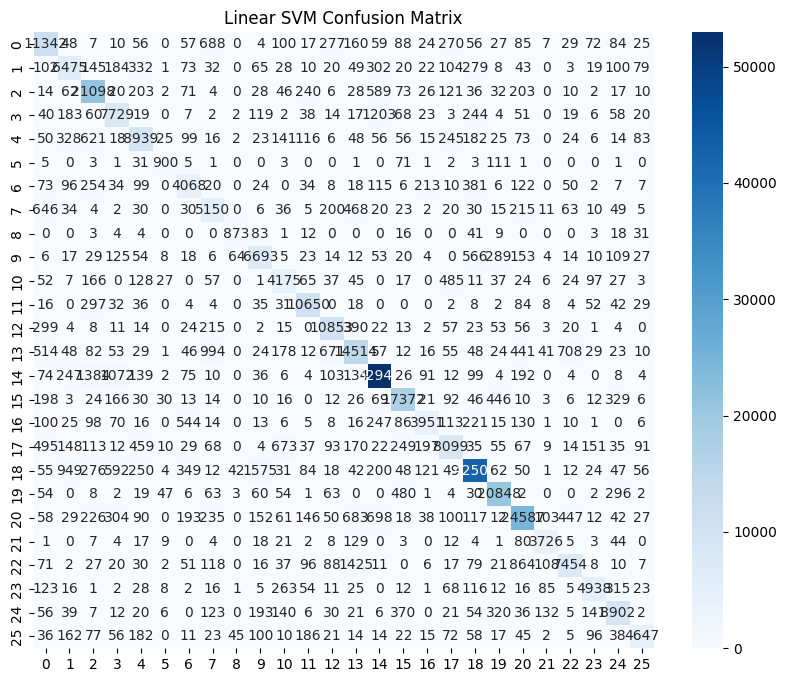

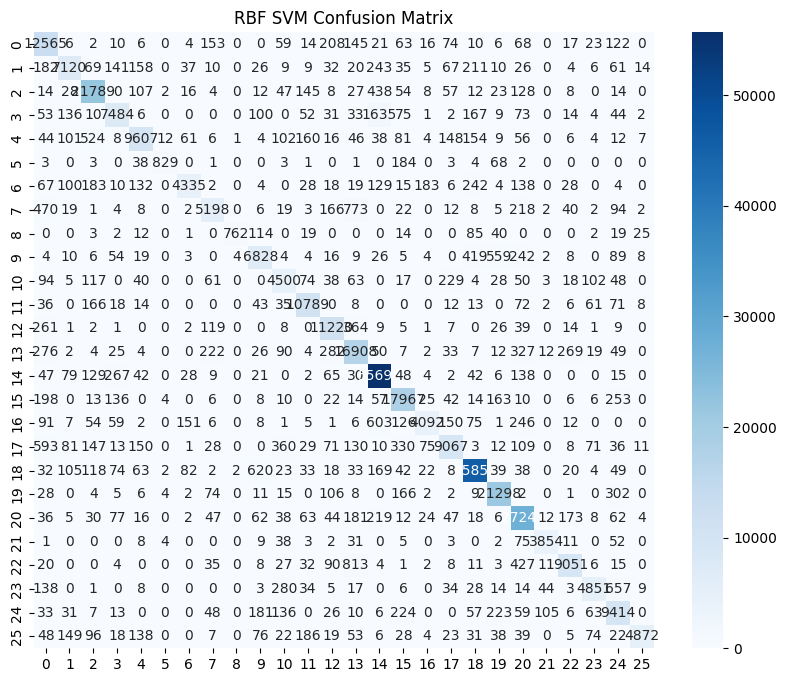

In [36]:
print(f"Linear SVM - F1 Score: {f1_linear:.2f}")
print(f"RBF SVM - F1 Score: {f1_rbf:.2f}")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_linear, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Linear SVM Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rbf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("RBF SVM Confusion Matrix")
plt.show()

# Logistic 

In [12]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    images_normalized, labels, test_size = 0.98, random_state=42, stratify=labels
    )

In [13]:
def logistic_regression_one_vs_all(X, y, num_classes):
    models = []
    # Binarize the labels for one vs all
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y)

    # Train a separate logistic regression model for each class
    for i in range(num_classes):
        print(f"Training model for class {i} vs all...")
        model = LogisticRegression(solver='liblinear', max_iter=4000, random_state=42)
        model.fit(X, y_bin[:, i])  # Fit each model to the binary labels for class i vs all
        models.append(model)

    return models, lb

In [14]:
def predict_one_vs_all(X, models):
    # Predict probabilities for each class
    probs = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        probs[:, i] = model.predict_proba(X)[:, 1]  # Get the probability for the positive class
    # Get the class with the highest probability for each sample
    y_pred = np.argmax(probs, axis=1)
    return y_pred

In [15]:
# Train logistic regression models (one vs all)
num_classes = len(np.unique(labels))  # 26 for A - Z
models, lb = logistic_regression_one_vs_all(X_val, y_val, num_classes)

Training model for class 0 vs all...
Training model for class 1 vs all...
Training model for class 2 vs all...
Training model for class 3 vs all...
Training model for class 4 vs all...
Training model for class 5 vs all...
Training model for class 6 vs all...
Training model for class 7 vs all...
Training model for class 8 vs all...
Training model for class 9 vs all...
Training model for class 10 vs all...
Training model for class 11 vs all...
Training model for class 12 vs all...
Training model for class 13 vs all...
Training model for class 14 vs all...
Training model for class 15 vs all...
Training model for class 16 vs all...
Training model for class 17 vs all...
Training model for class 18 vs all...
Training model for class 19 vs all...
Training model for class 20 vs all...
Training model for class 21 vs all...
Training model for class 22 vs all...
Training model for class 23 vs all...
Training model for class 24 vs all...
Training model for class 25 vs all...


In [16]:
y_pred = predict_one_vs_all(X_test, models)

# Confusion matrix and 
conf_matrix = confusion_matrix(y_test, y_pred)
# F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

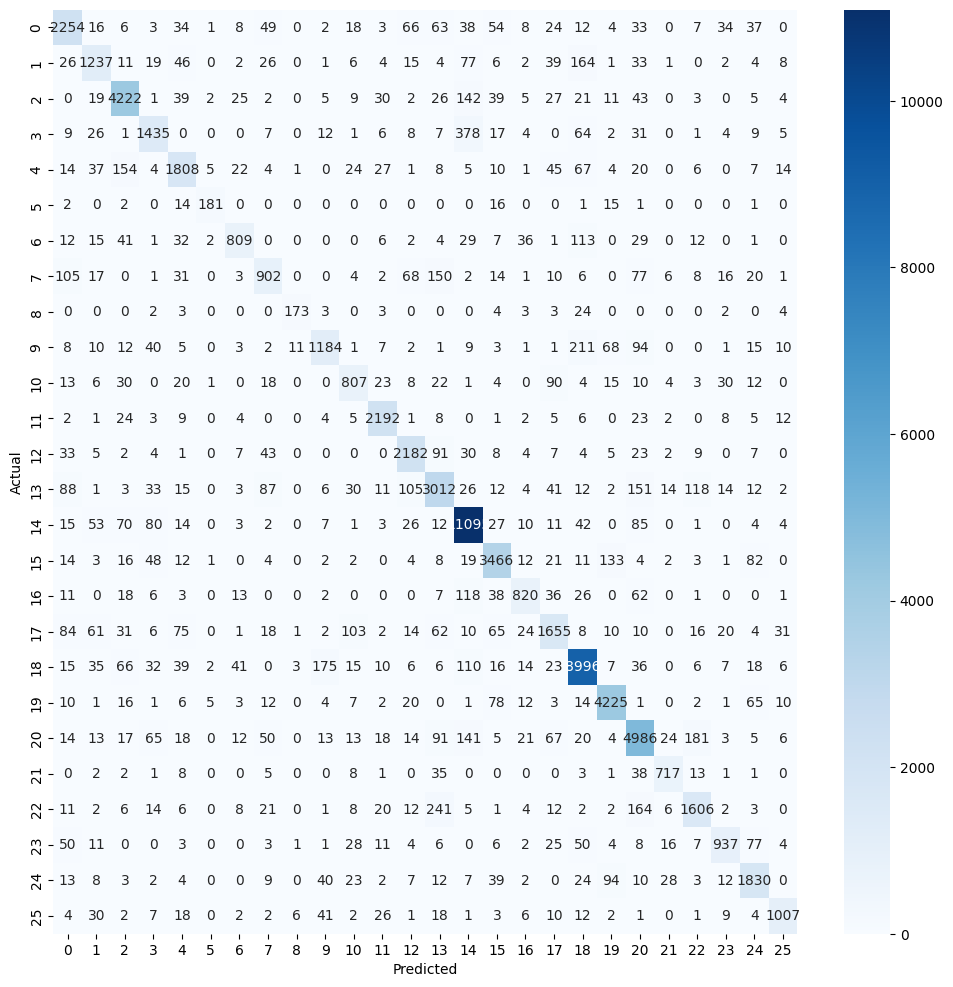

Accuracy: 0.86
F1 Score (Weighted): 0.85


In [17]:
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score (Weighted): {f1:.2f}")

# Neural Network

In [18]:
# ----------------Neural Network---------------------------------------------------
# Split training data into training and validation 
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [19]:
print(f"Final Training Data Shape: {X_train_final.shape}, Validation Data Shape: {X_val.shape}")
# Convert labels to categorical (one hot encoding)
y_train_cat = to_categorical(y_train_final, num_classes=26)
y_val_cat = to_categorical(y_val, num_classes=26)
y_test_cat = to_categorical(y_test, num_classes=26)

Final Training Data Shape: (238368, 784), Validation Data Shape: (59592, 784)


In [20]:
# Define First neural networks
def build_model_1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),#1D
        Dense(128, activation='relu'),
        Dense(26, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# Define Second neural networks
def build_model_2():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),#1D
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(26, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# Reshape data 
X_train_tf = X_train_final.reshape(-1, 28, 28, 1)
X_val_tf = X_val.reshape(-1, 28, 28, 1)
X_test_tf = X_test.reshape(-1, 28, 28, 1)

In [23]:
# Train and evaluate models
models = [build_model_1(), build_model_2()]
histories = []
for i, model in enumerate(models):
    print(f"Training Model {i+1}...")
    history = model.fit(X_train_tf, y_train_cat, validation_data=(X_val_tf, y_val_cat), epochs=10, batch_size=32)
    histories.append(history)

Training Model 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9087 - loss: 0.3258 - val_accuracy: 0.9698 - val_loss: 0.1049
Epoch 2/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9801 - loss: 0.0716 - val_accuracy: 0.9823 - val_loss: 0.0633
Epoch 3/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9869 - loss: 0.0438 - val_accuracy: 0.9834 - val_loss: 0.0578
Epoch 4/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9914 - loss: 0.0292 - val_accuracy: 0.9873 - val_loss: 0.0504
Epoch 5/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step - accuracy: 0.9936 - loss: 0.0201 - val_accuracy: 0.9872 - val_loss: 0.0528
Epoch 6/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9889 - val_loss: 0.0509
Epoch 7/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9962 - loss: 0.0117 - val_accuracy: 0.9883 - val_loss: 0.0565
Epoch 8/10
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9969 -

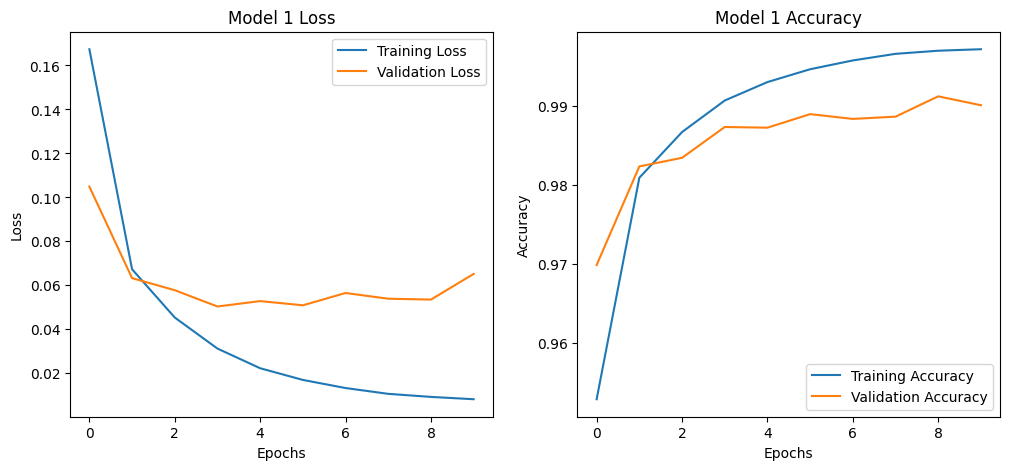

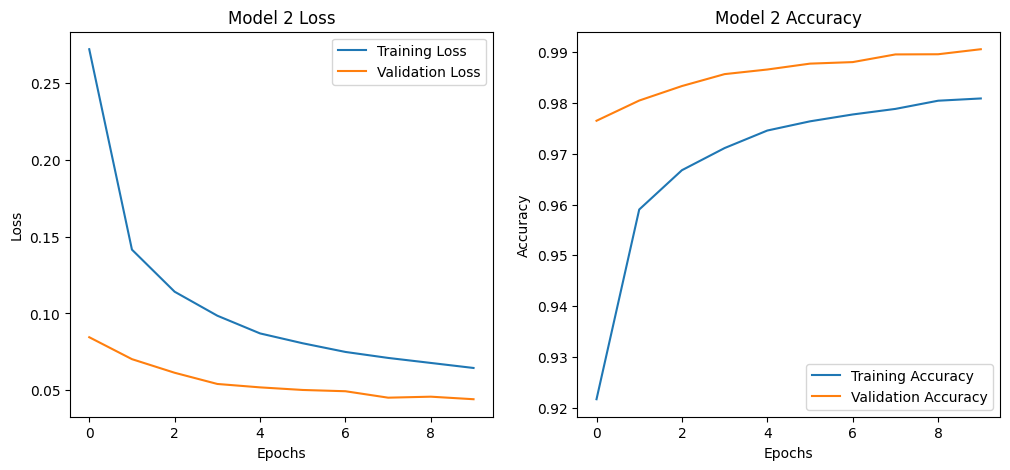

In [24]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Model {i+1} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Model {i+1} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()





In [25]:
# Save the best model
best_model = models[1]  # Assume Model 2 is better; adjust based on results
model_path = "best_model.h5"
best_model.save(model_path)
print(f"Best model saved to {model_path}")

Best model saved to best_model.h5


In [26]:
# Reload the model
loaded_model = tf.keras.models.load_model(model_path)

# Evaluate the best model on the test set
test_loss, test_accuracy = loaded_model.evaluate(X_test_tf, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.2f}")

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9901 - loss: 0.0422
Test Accuracy: 0.99


In [27]:
# Confusion matrix and F1 score
y_test_pred = loaded_model.predict(X_test_tf)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step


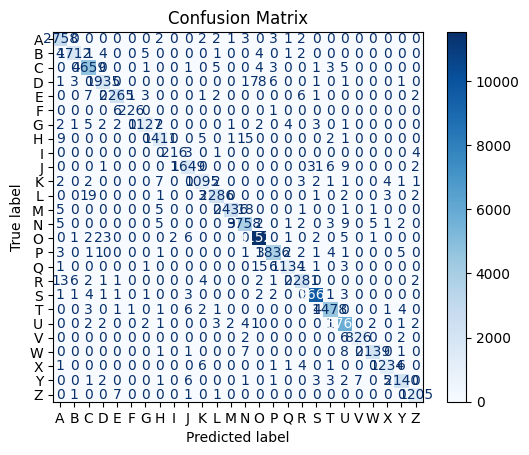

F1 Score (Weighted): 0.99


In [28]:
ConfusionMatrixDisplay(conf_matrix, display_labels=alphabet).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(f"F1 Score (Weighted): {f1:.2f}")

In [50]:
alphabet = [chr(i) for i in range(65,91)]  # A-Z

image_folder = "/kaggle/input/images1" 

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

    img_resized = cv2.resize(img, (28, 28))  # Resize to 28x28
    img_normalized = img_resized / 255.0  # Normalize pixel values
    img_reshaped = img_normalized.reshape(1, 28, 28, 1)  # Reshape for model input

    # Make a prediction
    pred = loaded_model.predict(img_reshaped)
    pred_class = alphabet[np.argmax(pred)]  # Get the predicted class

    print(f"Prediction for {image_name}: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for Figure_A.jpeg: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for Figure_y.jpeg: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for test3.jpeg: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for Figure_z.jpeg: Z
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for test1.jpeg: Z
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for Figure_o.jpeg: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for Figure_m.jpeg: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for test2.jpeg: N
